# EDA

*   Create a DataFrame from annotations to visualize our objects.
*   You can find the code in data/eda.ipynb
*   I did it on local machine and upload it to data/

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./data/eda.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,x,y,width,height
0,0.480508,0.898340,0.041250,0.030019
1,0.990586,0.770524,0.013750,0.018762
2,0.356875,0.666562,0.093750,0.036667
3,0.877812,0.514688,0.048125,0.027500
4,0.284570,0.873530,0.057500,0.020599


## Distributions

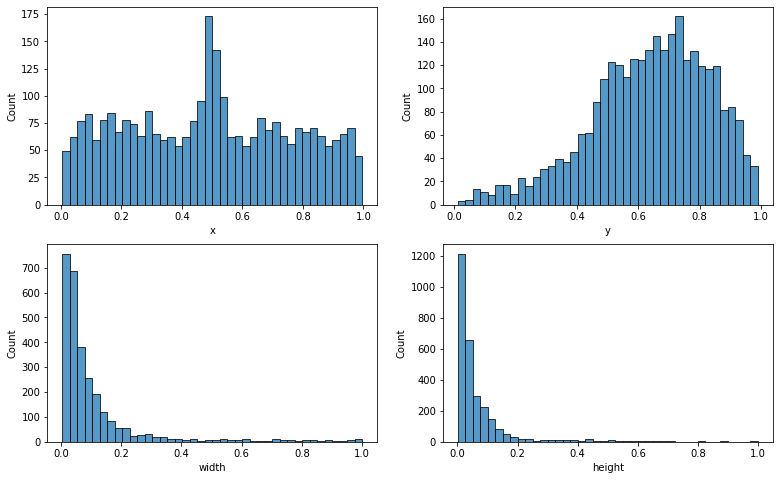

In [ ]:
plt.figure(figsize=(13,8))
bins=40

plt.subplot(2,2,1)
sns.histplot(data=df, x='x', bins=bins)

plt.subplot(2,2,2)
sns.histplot(data=df, x='y', bins=bins)

plt.subplot(2,2,3)
sns.histplot(data=df, x='width', bins=bins)

plt.subplot(2,2,4)
sns.histplot(data=df, x='height', bins=bins)

They make sense for number plate images



*   x values are well distributed, which means the cameraman did a good job :D
*   y values are well distributed as well, but, most of the objects are on top of our images.
*   both height and width make sense, because our object is licence plate and they all have almost similiar sizes.







## x vs y | height vs width

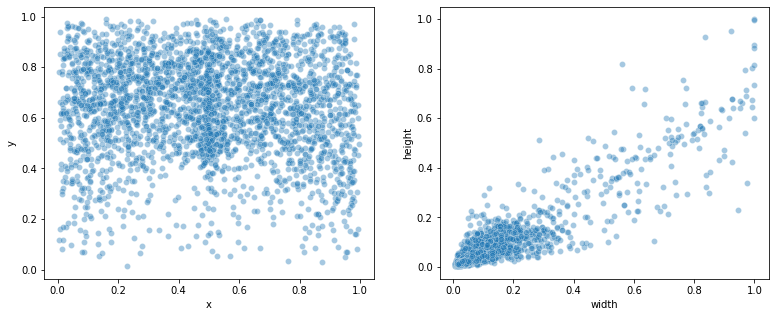

In [ ]:
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.scatterplot(data=df, x='x', y='y', alpha=.4)

plt.subplot(1,2,2)
sns.scatterplot(data=df, x='width', y='height', alpha=.4)


1.   As mentioned above, there is a lack in our dataset in buttom-half part of xy plane.
2.   As we can see, the center of our x axis is dense, it's beacuse humans put the object in the center of the camera.



# Darknet Setup

In [ ]:
# clone repo
!git clone https://github.com/AlexeyAB/darknet

## GPU

In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

In [ ]:
# make darknet
!make

## Weights

In [ ]:
# pre-trained weights on MS COCO dataset
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

In [ ]:
# pre-trained weights for the convolutional layers
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

## Generate train.txt and test.txt
* These files are not in official repo, but you can find them in my repository.

In [ ]:
!python generate_train.py
!python generate_test.py

## Configs
Wee need to change/create these files: (I configured them for our object, we just need to put them in right place)


*   data/obj.names
*   data/obj.data
*   cfg/yolov4-custom.cgf
*   cfg/yolov4-obj.cfg


# Training

## Configurations
https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects  


*   1 Epoch = images_in_train_txt / batch = 2000 / 32 = 62.5



## Train

In [ ]:
# Access Denied Error
!chmod +x ./darknet

In [ ]:
# set custom cfg to train mode 
%cd cfg
!sed -i 's/batch=1/batch=64/' yolov4-obj.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' yolov4-obj.cfg
%cd ..

In [3]:
!./darknet detector train ./data/obj.data ./cfg/yolov4-obj.cfg yolov4.conv.137 -dont_show -map

/bin/bash: ./darknet: No such file or directory


## Restart
I intrupted the training, we can restart training from our last weight.  
(every 100 iterations our weights are saved to backup folder in yolov4-obj_last.weights) (~every 30 minutes)  
(every 1000 iterations our weight are saved to backup folder in yolo-obj_xxxx.weights)

In [4]:
!./darknet detector train ./data/obj.data ./cfg/yolov4-obj.cfg ./backup/yolov4-obj_last.weights -dont_show -map

/bin/bash: ./darknet: No such file or directory


# Sanity Check

#### Setup

In [ ]:
# set custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov4-obj.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov4-obj.cfg
%cd ..

/content/drive/MyDrive/darknet/cfg
/content/drive/My Drive/darknet


In [ ]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

#### Sanity Check on COCO

In [ ]:
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/person.jpg

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv  

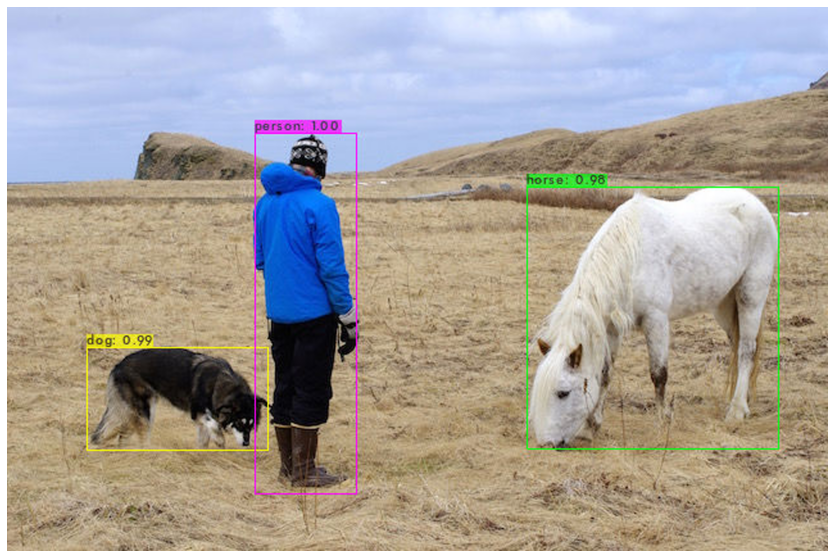

In [ ]:
imShow('./predictions.jpg')

#### Run on unseen data
I used the kaggle dataset for this.

In [ ]:
!./darknet detector test ./data/obj.data ./cfg/yolov4-obj.cfg ./backup/yolov4-obj_last.weights ../Cars354.png -thresh 0.3

CUDA status Error: file: ./src/dark_cuda.c : () : line: 39 : build time: Sep 20 2021 - 18:31:40 

 CUDA Error: no CUDA-capable device is detected
Darknet error location: ./src/dark_cuda.c, check_error, line #70
CUDA Error: no CUDA-capable device is detected: Bad file descriptor


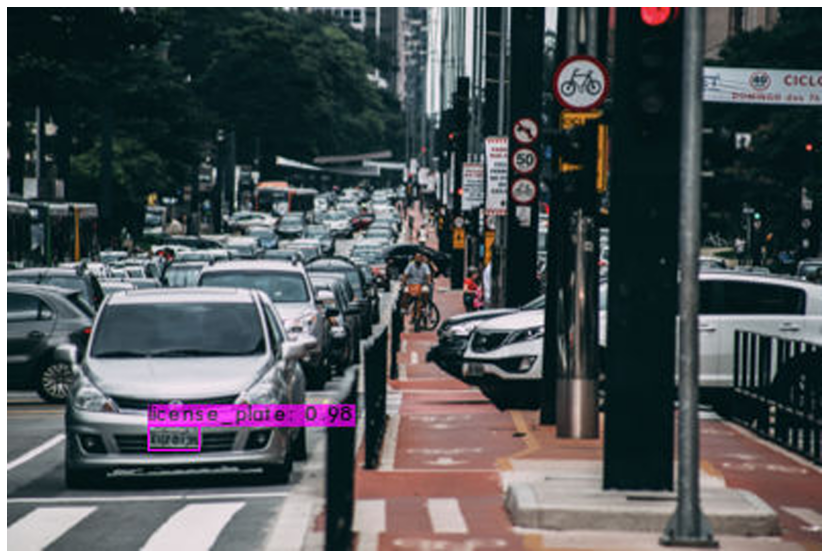

In [ ]:
imShow('./predictions.jpg')

**To process a list of images data/train.txt and save results of detection to result.json file use**


In [7]:
!./darknet detector test data/obj.data cfg/yolov4-obj.cfg backup/yolov4-obj_last.weights -ext_output -dont_show -out result.json < data/test.txt

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv  

# Metrics
**Use -map flag while training for charts**  
mAP-chart (red-line) and Loss-chart (blue-line) will be saved in root directory.  
mAP will be calculated for each 4 Epochs ~ 240 batches

**I lost my chart due to intruption, but the records are available in training outputs**

## Comparing the weights on validation set

## for yolov4-obj_last.weights (600 iterations) ~ 2hours

In [10]:
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg backup/yolov4-obj_last.weights

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv  

*   Precision: 50 %
*   Average Precision: 46.27 %
*   Recall: 61 %
*   F1-score: 55 %
*   Average IoU: 33.41 %
*   mAP@0.5: 46.27 %
*   Confusion Matrix:
    *   TP = 311
    *   FP = 313
    *   FN = 201
    *   unique_truth_count (TP+FN) = 512
    *   detections_count = 12327





### For best-weight.weights ~ 16hours

In [11]:
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg backup/custom.weights

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv  

*   Precision: 91 %
*   Average Precision: 89.80 %
*   Recall: 86 %
*   F1-score: 88 %
*   Average IoU: 74.06 %
*   mAP@0.5: 89.80 %
*   Confusion Matrix:
    *   TP = 439
    *   FP = 45
    *   FN = 73
    *   unique_truth_count (TP+FN) = 512
    *   detections_count = 805


# Challenges

## Dataset



I spent quiet a lot of time for finding a well annotated and large dataset for licence plates, but I didn't succeed.  
I checked all these:


*   [kaggle](https://www.kaggle.com/andrewmvd/car-plate-detection)
  *   This is a small dataset with 433 images, which I think is not enough for model to converge well.


*   https://platerecognizer.com/number-plate-datasets/
  *   waste of time (none of them are free)


*   http://www.zemris.fer.hr/projects/LicensePlates/english/results.shtml
  *   small

*   http://www.inf.ufrgs.br/~crjung/alpr-datasets/
*   https://github.com/detectRecog/CCPD





## Wrong path!

I spent a lot of time for finding a tensorflow/keras implementation for YOLO. But none of them worked properly.

And running darknet on windows wasn't so simple,
so I tried to run darknet on colab.

## GPU

Google colab limited my GPU usage.  
It got slower and slower and slower and I couldn't finish my training.

# Code

In [2]:
!pwd

/content


In [2]:
%cd drive/MyDrive/darknet

/content/drive/MyDrive/darknet
